# Libraries Setup

In [ ]:
%pip install qiskit==0.45.0
%pip install matplotlib
%pip install numpy
%pip install tqdm
%pip install qiskit-aer==0.12.0

In [ ]:
%pip check qiskit-machine-learning

In [27]:
import qiskit; import numpy as np; import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer, execute
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
from qiskit import qpy

from qoop.core import state, ansatz
from qoop.compilation.qcompilation import QuantumCompilation
from qoop.compilation.qst import QuantumStateTomography
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.evolution.environment import EEnvironmentMetadata
from qoop.evolution.environment import EEnvironment

# Data Prep

In [3]:
# Step 1: Generate synthetic data
# Create a binary classification dataset
X, y = make_blobs(n_samples=500, n_features=2, centers=2, random_state=41)
y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# GA 

### Idea 1: each state = each circuit

Data point 1: [ 0.80348562  0.4332676  -1.11871174 -1.44189599]
Data point 2: [-0.30339529  0.94893829 -0.67925163  0.10800143]
Data point 3: [-1.13414329 -1.94069116  0.08212212 -0.72121079]
Data point 4: [0.84435877 0.15248278 1.27729677 0.44427208]


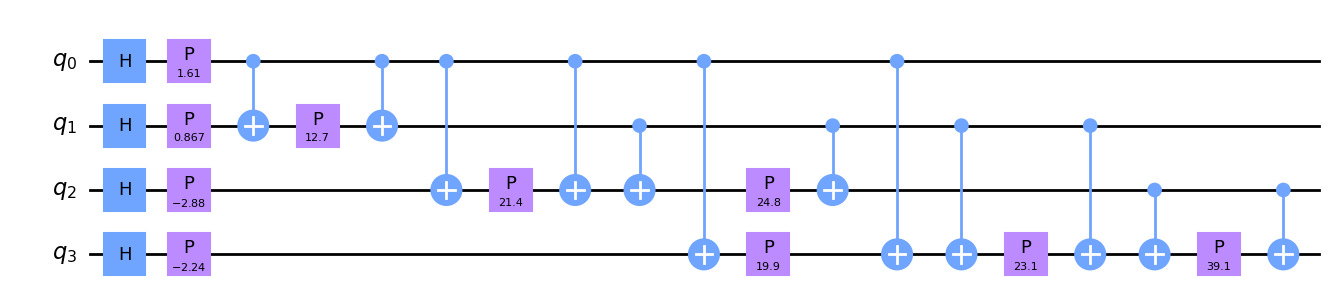

In [ ]:
# Step 2: Define a quantum feature map
FeatureM = ZZFeatureMap(feature_dimension=2, reps=1)

FM = ZZFeatureMap(feature_dimension=4, reps=1)
FM1 = ZZFeatureMap(feature_dimension=4, reps=1)
FM2 = ZZFeatureMap(feature_dimension=4, reps=1)
FM3 = ZZFeatureMap(feature_dimension=4, reps=1)

for i, Fm in enumerate([FM, FM1, FM2, FM3]):
    x = X_test[i]  # Select one data point
    print(f"Data point {i+1}: {x}")
    
    # Map data point to parameters
    param_dict = { x[j] for j in range(len(x))}  # x[0], x[1], ...
    
    # Assign parameters to the feature map
    Fm.assign_parameters(param_dict, inplace=True)# Decompose and draw the circuit
    
FM.decompose().draw(output="mpl", style="clifford", fold=20)


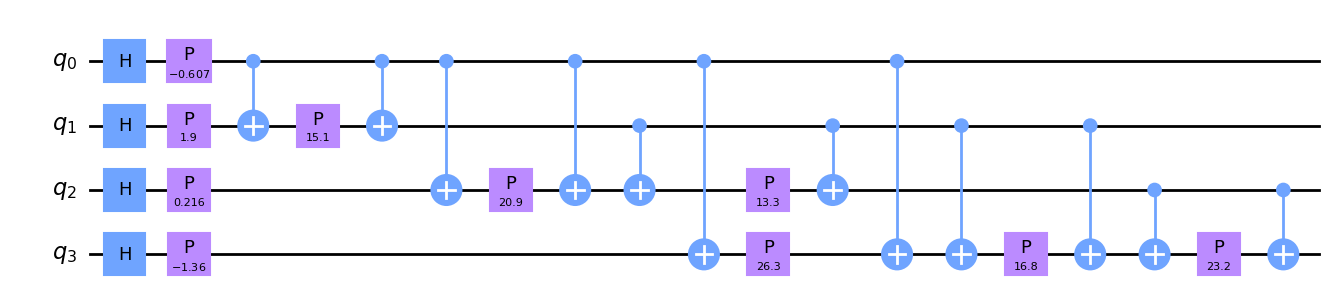

In [12]:
FM1.decompose().draw(output="mpl", style="clifford", fold=20)


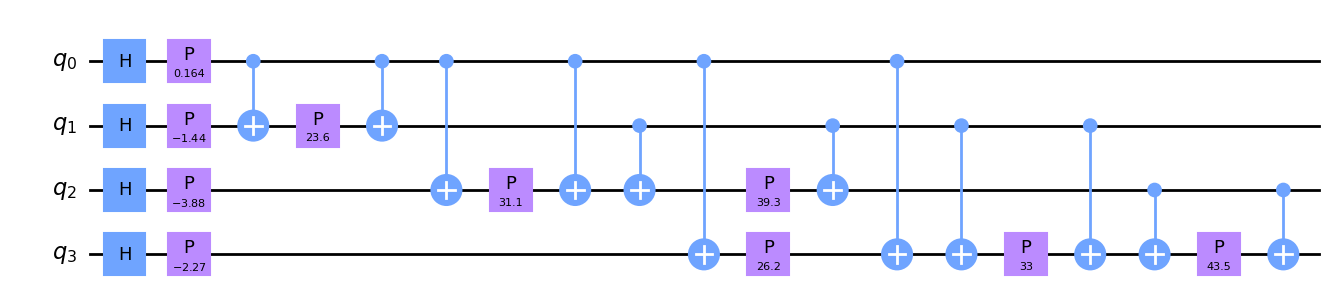

In [13]:
FM2.decompose().draw(output="mpl", style="clifford", fold=20)


### GA part

In [ ]:


def randomfitness(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = state.rx_layer
    ).fit(num_steps = 10)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

def FM0_fitness(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = FM
    ).fit(num_steps = 10)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

def FM1_fitness(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = FM1
    ).fit(num_steps = 10)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

def FM2_fitness(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = FM2
    ).fit(num_steps = 10)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value
def FM3_fitness(qc: qiskit.QuantumCircuit):
    qsp = QuantumStatePreparation(
        u = qc,
        target_state = FM3
    ).fit(num_steps = 10)
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1] # Fitness value

In [ ]:
env_metadata = EEnvironmentMetadata(
    num_qubits = 4, # As its name
    depth = 4, # Ansatz depth you want
    num_circuit = 20, # Number of ansatz per generation
    num_generation = 6, # Number of generation/iteration for GA
    prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

env = EEnvironment(
    metadata = env_metadata,
    fitness_func = randomfitness

).evol()

# Some Function

In [ ]:
def Define_Eval_QSVM(X_train, y_train,y_test,feature_dimension , num_rep):
    # Step 2:
    FeatureM = ZZFeatureMap(feature_dimension=feature_dimension, reps=num_rep)
    
    # Step 3: Use QuantumKernel to compute the kernel matrix
    qasm = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=FeatureM,quantum_instance=qasm) # Encode each data point into each separated state (500 data points -> 500 states) 
    #and create K(xi,xj) = [state ij;...], is computing each state with each other, 500 states -> K matrix (500x500)

    # Step 4: Train a QSVM
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train) #fit(df_train[features], df_train['Species'])

    # Step 5: Evaluate the QSVM
    accuracy = qsvc.score(X_test, y_test)
    print (f"Test Accuracy: {accuracy * 100:.2f}% ")


def load_circuits(fitness_levels):
    circuits = []
    for fitness in range(1, fitness_levels+1):
        print(fitness)
        file_name = f'4qubits_FM{fitness}_fitness_2024-12-02/best_circuit.qpy'
        with open(file_name, 'rb') as fd:
            circuit = qpy.load(fd)[0]
            print(circuit)  # Print if needed
            circuits.append(circuit)
    return circuits



In [ ]:
all_circuits = load_circuits(3)

# For loop function for running a random data set (2-3D) then run Define_Eval_QSVM() to measure accu


In [ ]:

for i in range (4,9):
    # Step 1: Generate synthetic data
    # Create a binary classification dataset
    [X, y] = make_blobs(n_samples=150, n_features=2, centers=2, random_state = i)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  


    #print(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], label='Testing Data', alpha=0.8, marker='^')
    plt.title(f"Dataset Visualization (Random State={i})")
    plt.show()
    for k in range(1,10):
        print(f'the number of reps is {k}')
        Define_Eval_QSVM(X_train, y_train,y_test, feature_dimension = 2, num_rep = k )

In [ ]:
for i in range (1,4): 
    # Step 1: Generate synthetic data
    # Create a binary classification dataset
    [X, y] = make_blobs(n_samples=150, n_features=3, centers=2, random_state=i)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  

    #print(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], label='Testing Data', alpha=0.8, marker='^')
    plt.title(f"Dataset Visualization (Random State={i})")
    plt.show()
    for k in range (1,10):
        print(f'the number of reps is {k}')
        Define_Eval_QSVM(X_train, y_train,y_test, feature_dimension = 3, num_rep = k )

# Check for Circuit execution is equally


In [ ]:
# Testing shots count through Aer device
from qiskit_aer import Aer
from qiskit import execute
backend = Aer.get_backend('statevector_simulator')
job = execute(all_circuits[1], backend, shots=1024)
result = job.result()

# Get the result
counts = result.get_counts(layer)
print("\n 1. Resulting Counts:", counts)

##
job = execute(circuits, backend, shots=1024)
result = job.result()

# Get the result
counts = result.get_counts(circuits)
print("\n 2. Resulting Counts:", counts)

# Manually buid QSVM

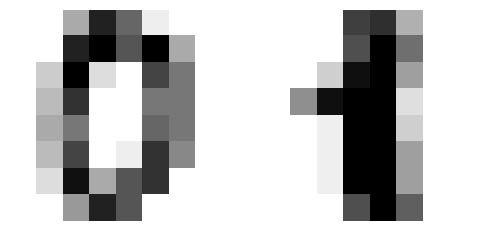

In [17]:
digits = load_digits(n_class=2)

# Plot example '0' and '1'
fig, axs = plt. subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits. images[0], cmap=plt.cm.gray_r, interpolation= 'nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Data =[1,2]
sample_train =[1,2]
sample_test =[1,2]

In [18]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=22)
# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform (sample_test)
# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)
# Scale
samples = np.append(sample_train, sample_test,axis=0)
minmax_scale = MinMaxScaler((-1, 1)). fit (samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)
# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test [:test_size]
label_test = label_test [:test_size]

print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])


[-0.79923362  0.26571862 -0.16474421  0.17815209] 0
[0.41948352 0.83602799 0.72200828 0.373356  ] 1


d:\Anaconda-Env\GAqiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


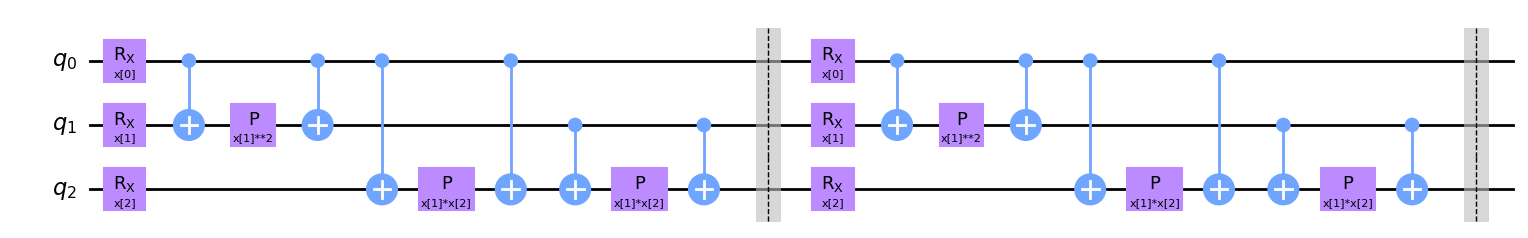

In [19]:
qubits = 3
repeats = 2
x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)
for _ in range (repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)        
    for i in range(qubits):
        for j in range(i + 1, qubits) :
            var_custom.cx(i, j)
            var_custom.p(x[1] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()

var_custom.draw('mpl')

In [20]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear',insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [ ]:
"""zz_circuit = zz_kernel.contruct_circuit(sample_train[0],sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')"""

AttributeError: 'QuantumKernel' object has no attribute 'contruct_circuit'

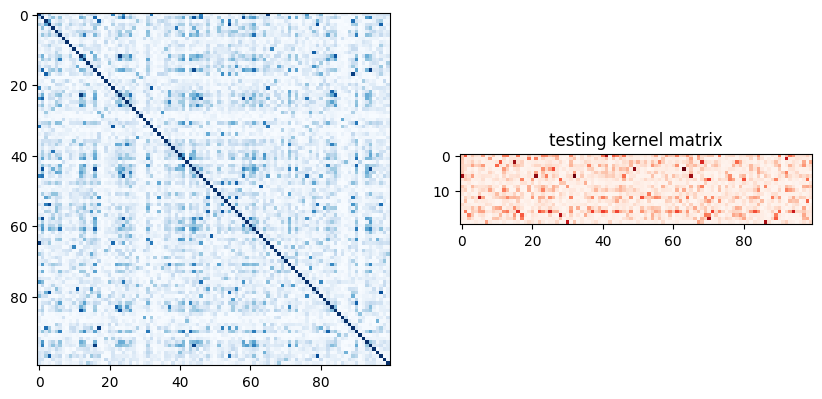

In [ ]:
matrix_train = zz_kernel.evaluate(x_vec = sample_train)
matrix_test = zz_kernel.evaluate(x_vec = sample_test, y_vec = sample_train)

print(matrix_test)

fig, axs = plt.subplots(1,2, figsize =(10,5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin = 'upper',cmap ='Blues')
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin = 'upper',cmap ='Reds')
axs[1].set_title("testing kernel matrix"); plt.show()

In [28]:
backend =Aer.get_backend('statevector_simulator')
job = execute(zz_circuit, backend, shots=8192,
              seed_simultor=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)
rs=counts['0000']/sum(counts.values()) #incase of 4 qubits

NameError: name 'zz_circuit' is not defined

In [ ]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(matrix_train, label_train)
zzcb_score = zzcb_svc.score(matrix_test, label_test)

print(f'Callable kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.9


In [ ]:
classical_kernels = ['Linear', 'poly', 'rbf','sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_test, label_test)
    classical_score = classical_svc.score(sample_test, label_test)